<a href="https://colab.research.google.com/github/abishekparajuli-np/FaceEmotionDetection/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf

In [2]:
import kagglehub
path = kagglehub.dataset_download("msambare/fer2013")

Using Colab cache for faster access to the 'fer2013' dataset.


In [3]:
train = f"{path}/train"
test  = f"{path}/test"

In [4]:
image_size=48
batch_size=64
num_classes=7

In [5]:
emotions=['angry','disgust','fear','happy','neutral','sad','surprise']

In [6]:
def count_images(directory):
    counts={}
    for emotion in emotions:
        path = os.path.join(directory,emotion)
        if os.path.exists(path):
            counts[emotion]=len(os.listdir(path))
    return counts

In [7]:
train_counts=count_images(train)
test_counts=count_images(test)

In [8]:
train_counts

{'angry': 3995,
 'disgust': 436,
 'fear': 4097,
 'happy': 7215,
 'neutral': 4965,
 'sad': 4830,
 'surprise': 3171}

In [9]:
test_counts

{'angry': 958,
 'disgust': 111,
 'fear': 1024,
 'happy': 1774,
 'neutral': 1233,
 'sad': 1247,
 'surprise': 831}

In [10]:
#Test and Train Data Distribution Visualization

In [11]:
import matplotlib.pyplot as plt
import seaborn as sna

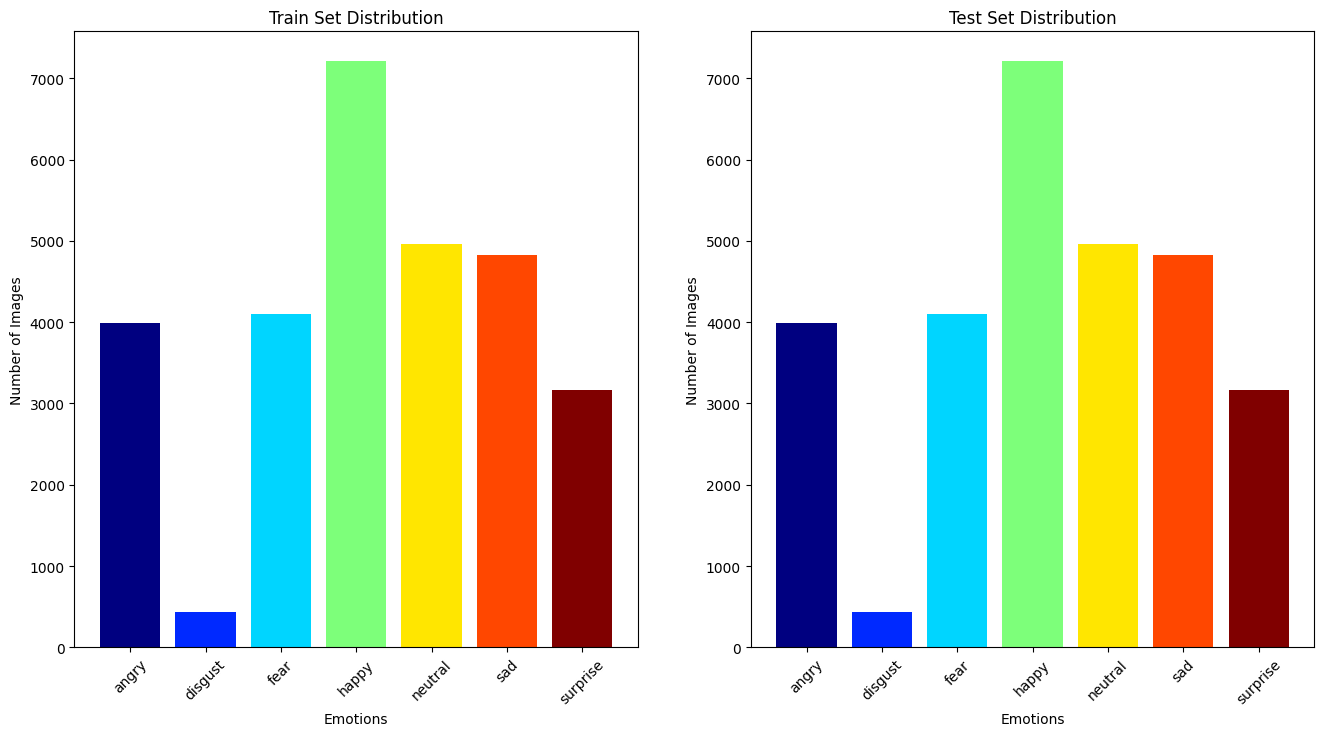

In [12]:
fig,axes=plt.subplots(1,2,figsize=(16,8))
colors=plt.cm.jet(np.linspace(0,1,len(emotions)))

#train_set
ax1=axes[0]
bars1 = ax1.bar(train_counts.keys(),train_counts.values(),color=colors)
ax1.set_title("Train Set Distribution")
ax1.set_xlabel('Emotions')
ax1.set_ylabel('Number of Images')
ax1.tick_params(axis='x',rotation=45)

#test_set
ax2=axes[1]
bars2 = ax2.bar(train_counts.keys(),train_counts.values(),color=colors)
ax2.set_title("Test Set Distribution")
ax2.set_xlabel('Emotions')
ax2.set_ylabel('Number of Images')
ax2.tick_params(axis='x',rotation=45)


plt.show()

In [13]:
print('Most Samples={0}({1})'.format(max(train_counts,key=train_counts.get),max(train_counts.values())))
print('Least Samples={0}({1})'.format(min(train_counts,key=train_counts.get),min(train_counts.values())))

Most Samples=happy(7215)
Least Samples=disgust(436)


In [14]:
#Sample Image for eacg category

In [15]:
import cv2

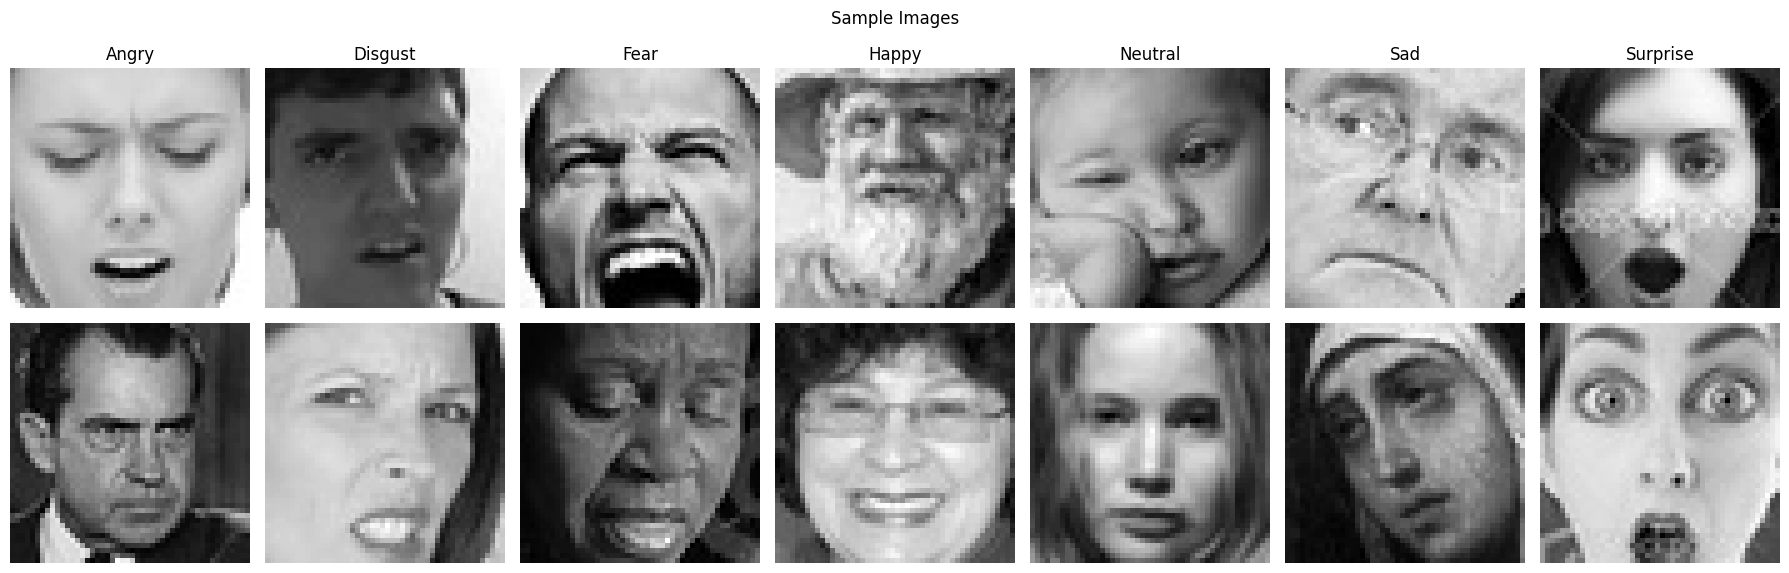

In [16]:
fig,axes=plt.subplots(2,7,figsize=(18,6))

for idx,emotion in enumerate(emotions):
    emotion_path=os.path.join(train,emotion)
    sample_images = os.listdir(emotion_path)[: 2]

    for row,imag_name in enumerate(sample_images):
        img_path=os.path.join(emotion_path, imag_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        axes[row, idx].imshow(img, cmap='gray')
        axes[row,idx].axis('off')
        if row == 0:
            axes[row,idx].set_title(emotion.capitalize())

plt.suptitle('Sample Images')
plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
train_data= ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,

    width_shift_range=0.15,
    height_shift_range=0.15,

    zoom_range=0.15,
    shear_range=0.15,

    horizontal_flip=True,
    fill_mode='nearest',

    validation_split=0.15
)

test_data = ImageDataGenerator(rescale=1./255)

In [19]:
train_generator=train_data.flow_from_directory(
    train,
    target_size=(image_size,image_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator=train_data.flow_from_directory(
    train,
    target_size=(image_size,image_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator=test_data.flow_from_directory(
    test,
    target_size=(image_size,image_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 24406 images belonging to 7 classes.
Found 4303 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [20]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [21]:
train_generator.samples

24406

In [22]:
validation_generator.samples

4303

In [23]:
test_generator.samples

7178

In [24]:
#Real and Augumented Image

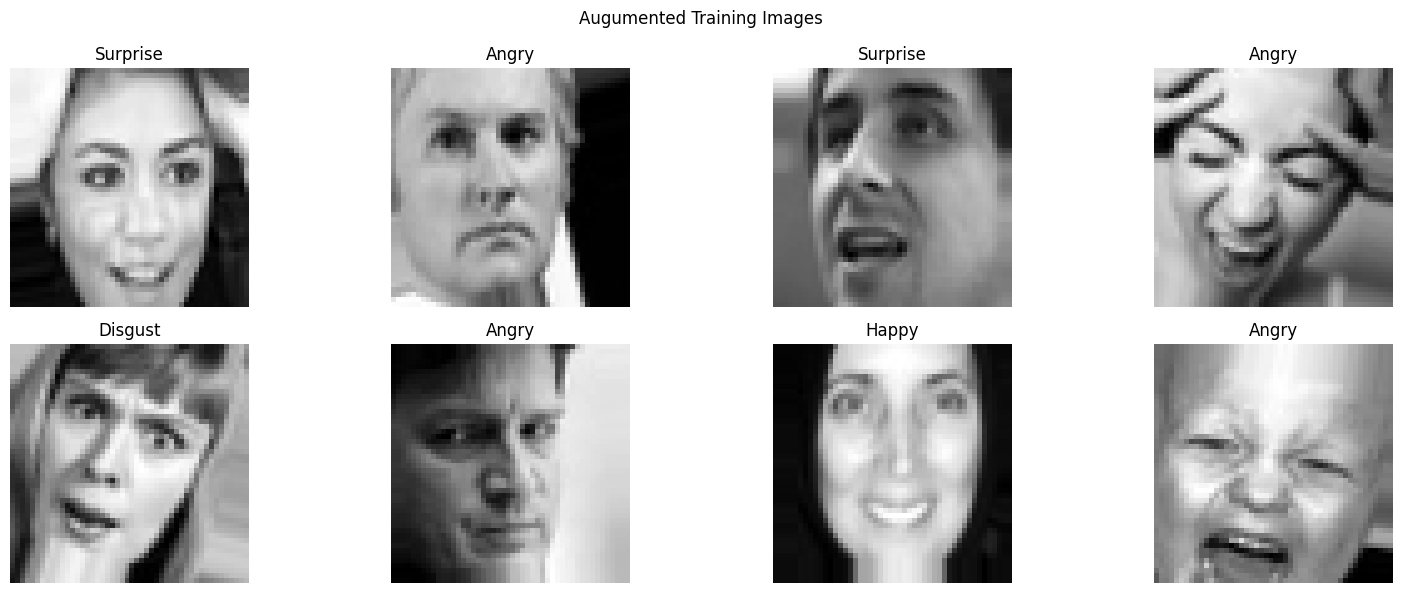

In [25]:
def visualize_augmentation(generator,num_images=8):
    batch_x, batch_y =next(generator)

    fig,axes=plt.subplots(2,num_images//2,figsize=(16,6))
    axes=axes.flatten()

    for i in range(num_images):
        axes[i].imshow(batch_x[i].reshape(image_size,image_size),cmap='gray')
        label_idx=np.argmax(batch_y[i])
        axes[i].set_title(emotions[label_idx].capitalize())
        axes[i].axis('off')

    plt.suptitle('Augumented Training Images')
    plt.tight_layout()
    plt.show()

visualize_augmentation(train_generator)

In [26]:
#Handling Unbalanced Class

In [27]:
from sklearn.utils.class_weight import compute_class_weight

In [28]:
class_labels=train_generator.classes
class_weights=compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

class_weight_dict=dict(enumerate(class_weights))

In [29]:
#Visualize Class Weight

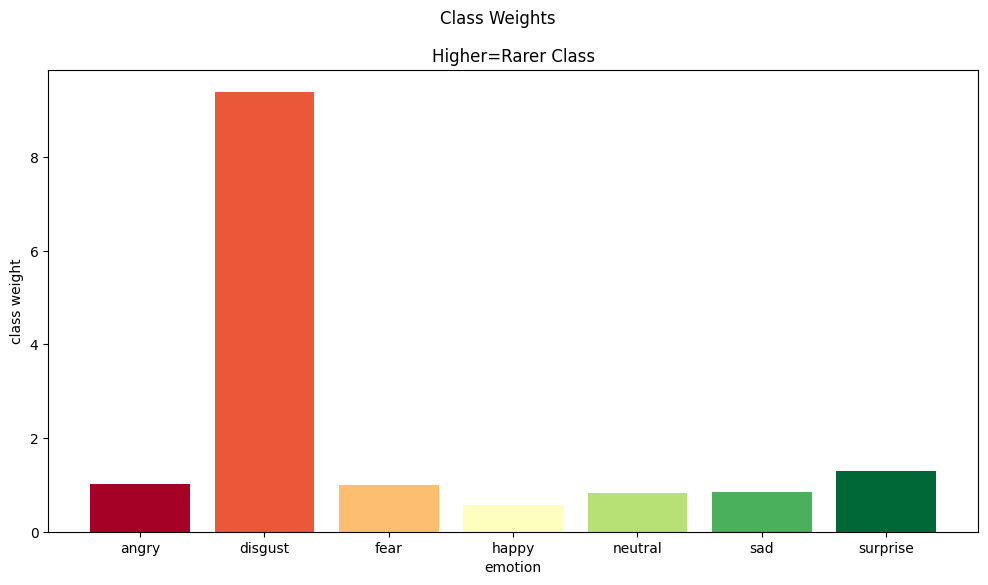

In [30]:
plt.figure(figsize=(12,6))
plt.bar(emotions,class_weights,color=plt.cm.RdYlGn(np.linspace(0,1,len(emotions))))
plt.suptitle('Class Weights')
plt.title('Higher=Rarer Class')
plt.xlabel('emotion')
plt.ylabel('class weight')
plt.show()

In [31]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
     Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D,Input, Activation, Add)
from tensorflow.keras.regularizers import l2

In [32]:
def build_emotion_cnn(input_shape=(48,48,1),num_classes=7):

    model = Sequential(name='EmotionCNN')
    #Detect Edges, simple textures, basic gradients
    model.add(Conv2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        kernel_regularizer=l2(0.001),
        input_shape=input_shape,
        name='conv1_1'
    ))

    model.add(BatchNormalization(name='bn1_1'))
    model.add(Activation('relu',name='relu1_1'))
    #Second  conv layer for more expressive feature extractiom
    model.add(Conv2D(64, (3,3),padding='same',kernel_regularizer=l2(0.001),name='conv1_2'))

    model.add(BatchNormalization(name='bn1_2'))
    model.add(Activation('relu',name='relu1_2'))

    model.add(MaxPooling2D(pool_size=(2,2),name='pool1'))
    model.add(Dropout(0.25,name='droupout1'))

    #Detect Textures Simple Shapes Local Patterns

    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001),name='conv2_1'))

    model.add(BatchNormalization(name='bn2_1'))
    model.add(Activation('relu',name='relu2_1'))

    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001),name='conv2_2'))

    model.add(BatchNormalization(name='bn2_2'))
    model.add(Activation('relu',name='relu2_2'))

    model.add(MaxPooling2D(pool_size=(2,2),name='pool2'))
    model.add(Dropout(0.25, name='droupout2'))
    #Detect Facial Part
    model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001),name='conv3_1'))

    model.add(BatchNormalization(name='bn3_1'))
    model.add(Activation('relu',name='relu3_1'))

    model.add(Conv2D(filters=256,kernel_size=(3,5),padding='same',kernel_regularizer=l2(0.001),name='con3_2'))

    model.add(BatchNormalization(name='bn3_2'))
    model.add(Activation('relu',name='relu3_2'))

    model.add(MaxPooling2D(pool_size=(2,2),name='pool3'))
    model.add(Dropout(0.25,name='dropout3'))

    #Detect Expression Specific Pattern , Emotions

    model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001),name='conv4_1'))

    model.add(BatchNormalization(name='bn4_1'))
    model.add(Activation('relu',name='relu4_1'))

    model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001),name='conv4_2'))

    model.add(BatchNormalization(name='bn4_2'))
    model.add(Activation('relu',name='relu4_2'))

    model.add(MaxPooling2D(pool_size=(2,2),name='pool4'))
    model.add(Dropout(0.25,name='dropout4'))

    #Convert 3d feature map to 1d vector
    model.add(Flatten(name='flatten'))

    model.add(Dense(512,kernel_regularizer=l2(0.001),name='fc1'))
    model.add(BatchNormalization(name='bn_fc1'))
    model.add(Activation('relu',name='relu_fc1'))
    model.add(Dropout(0.5,name='dropout_fc1'))

    model.add(Dense(256,kernel_regularizer=l2(0.001),name='fc2'))
    model.add(BatchNormalization(name='bn_fc2'))
    model.add(Activation('relu',name='relu_fc2'))
    model.add(Dropout(0.5,name='dropout_fc2'))

    model.add(Dense(num_classes,activation='softmax',name='output'))

    return model


In [33]:
model=build_emotion_cnn()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.summary()

Model: "EmotionCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 48, 48, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_1 (Activation)            │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 48, 48, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_2 (Activation)            │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ droupout1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 24, 24, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_1 (Activation)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 24, 24, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_2 (Activation)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ droupout2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 12, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_1 (Activation)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ con3_2 (Conv2D)                 │ (None, 12, 12, 256)    │       983,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 12, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_2 (Activation)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 6, 6, 512)      │     1,180,16

 Total params: 7,581,127 (28.92 MB)

 Trainable params: 7,575,751 (28.90 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [35]:
from tensorflow.keras.optimizers import Adam,SGD

In [36]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [37]:
model.count_params()

7581127

In [38]:
from tensorflow.keras. callbacks import (
    EarlyStopping, ReduceLROnPlateau,
    ModelCheckpoint, TensorBoard
)

In [39]:
callbacks=[

    EarlyStopping(monitor='val_loss',patience=15,restore_best_weights=True,verbose=1,mode='min'
    ),
    ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=1e-7,verbose=1,mode='min'),
    ModelCheckpoint(filepath='best_emotion_model.keras',monitor='val_accuracy',save_best_only=True,verbose=1,mode='max'),
    TensorBoard(log_dir='./logs',histogram_freq=1,write_graph=True)
]

In [40]:
steps_per_epoch=train_generator.samples // batch_size
validation_step = validation_generator.samples // batch_size

In [41]:
history = model.fit(
    train_generator,
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_step,
    callbacks=callbacks,
    class_weight=class_weight_dict,  # Handle imbalance
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.1628 - loss: 5.0536
Epoch 1: val_accuracy improved from -inf to 0.24604, saving model to best_emotion_model.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 188s 434ms/step - accuracy: 0.1627 - loss: 5.0525 - val_accuracy: 0.2460 - val_loss: 3.6130 - learning_rate: 0.0010
Epoch 2/100
  1/381 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.2500 - loss: 3.9509

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.24604 to 0.24767, saving model to best_emotion_model.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2500 - loss: 3.9509 - val_accuracy: 0.2477 - val_loss: 3.6121 - learning_rate: 0.0010
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.1603 - loss: 3.4385
Epoch 3: val_accuracy did not improve from 0.24767
381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.1603 - loss: 3.4378 - val_accuracy: 0.0336 - val_loss: 2.7604 - learning_rate: 0.0010
Epoch 4/100
  1/381 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.0781 - loss: 2.8896
Epoch 4: val_accuracy did not improve from 0.24767
381/381 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.0781 - loss: 2.8896 - val_accuracy: 0.0443 - val_loss: 2.7525 - learning_rate: 0.0010
Epoch 5/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.1768 - loss: 2.6481
Epoch 5: val_accuracy did not improve from 0.24767
381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accurac

In [42]:
#Visualising Training Metrics

In [47]:
def plot_training_history(history):
  fig, axes= plt.subplots(1,2,figsize=(12,6))

  ax1=axes[0]
  ax1.plot(history.history['accuracy'],label='Training Accuracy',linewidth=2)
  ax1.plot(history.history['val_accuracy'],label='Validation Accuracy',linewidth=2)
  ax1.set_title('Model Accuracy Over Epcohs')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax1.legend(loc='lower right')
  ax1.grid(True)

  best_val_acc=max(history.history['val_accuracy'])
  best_epoch=history.history['val_accuracy'].index(best_val_acc)
  print("{0},{1}".format(best_val_acc,best_epoch))
  ax2=axes[1]
  ax2.plot(history.history['loss'],label='Training Loss',linewidth=2)
  ax2.plot(history.history['val_loss'],label='Validation Loss',linewidth=2)
  ax2.set_title('Model Loss Over Epochs')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax2.legend(loc='upper right')
  ax2.grid(True)

  best_val_loss = min(history.history['val_loss'])
  best_loss_epoch=history.history['val_loss'].index(best_val_loss)
  print("{0},{1}".format(best_val_loss,best_loss_epoch))

  plt.tight_layout()
  plt.show()

0.6091417670249939,99
1.2079110145568848,98


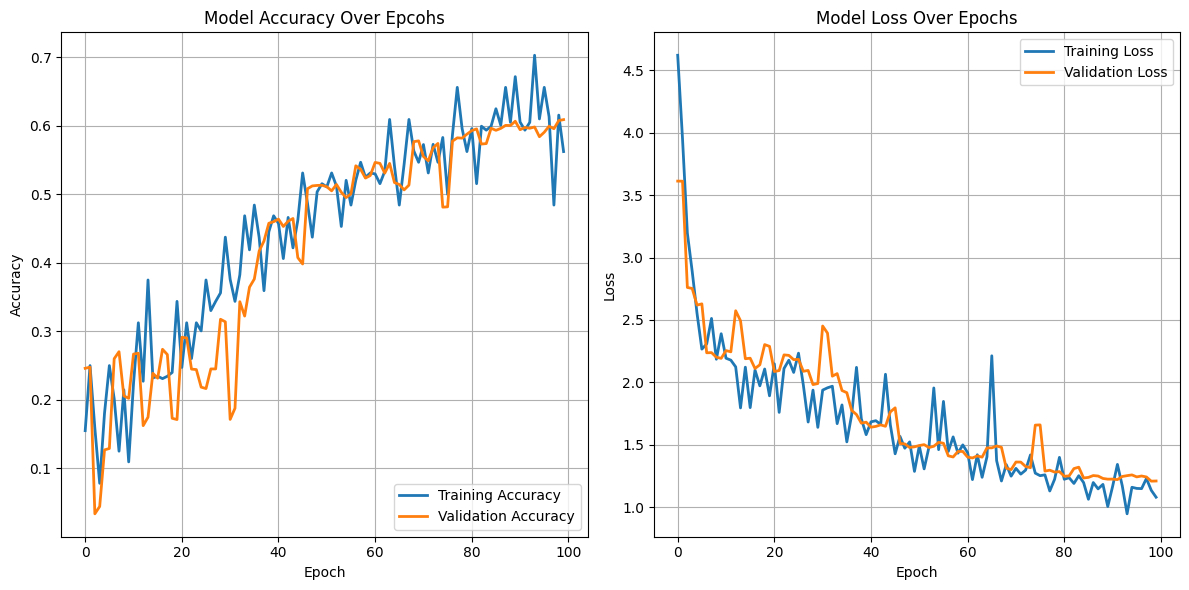

In [48]:
plot_training_history(history)

In [49]:
from tensorflow.keras.models import load_model

In [51]:
best_model=load_model('best_emotion_model.keras')
print('Ealuating On Test Set')
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

Ealuating On Test Set


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 252ms/step - accuracy: 0.5940 - loss: 1.2220


In [52]:
test_loss

1.1652660369873047

In [53]:
test_accuracy

0.6290053129196167

In [54]:
from sklearn.metrics import classification_report

In [56]:
test_generator.reset()
y_pred_probs= best_model.predict(test_generator, verbose=1)
y_pred=np.argmax(y_pred_probs, axis=1)
y_true= test_generator.classes

report=classification_report(y_true,y_pred, target_names=[e for e in emotions],digits=4)
print(report)

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step
              precision    recall  f1-score   support

       angry     0.5157    0.6013    0.5552       958
     disgust     0.3347    0.7568    0.4641       111
        fear     0.5432    0.2822    0.3715      1024
       happy     0.9042    0.8196    0.8598      1774
     neutral     0.5222    0.7437    0.6136      1233
         sad     0.5255    0.4298    0.4729      1247
    surprise     0.7371    0.7930    0.7641       831

    accuracy                         0.6290      7178
   macro avg     0.5832    0.6323    0.5859      7178
weighted avg     0.6413    0.6290    0.6228      7178



In [57]:
#confusion_matrix

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [64]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Counts
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=classes, yticklabels=classes,
        ax=axes[0]
    )
    axes[0].set_title('Confusion Matrix (Counts)')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Percent annotations
    annot_percent = np.array([[f"{v*100:.2f}%" for v in row] for row in cm_normalized])

    sns.heatmap(
        cm_normalized, annot=annot_percent, fmt='', cmap='RdYlGn',
        xticklabels=classes, yticklabels=classes,
        ax=axes[1]
    )
    axes[1].set_title('Confusion Matrix (Normalized)')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()


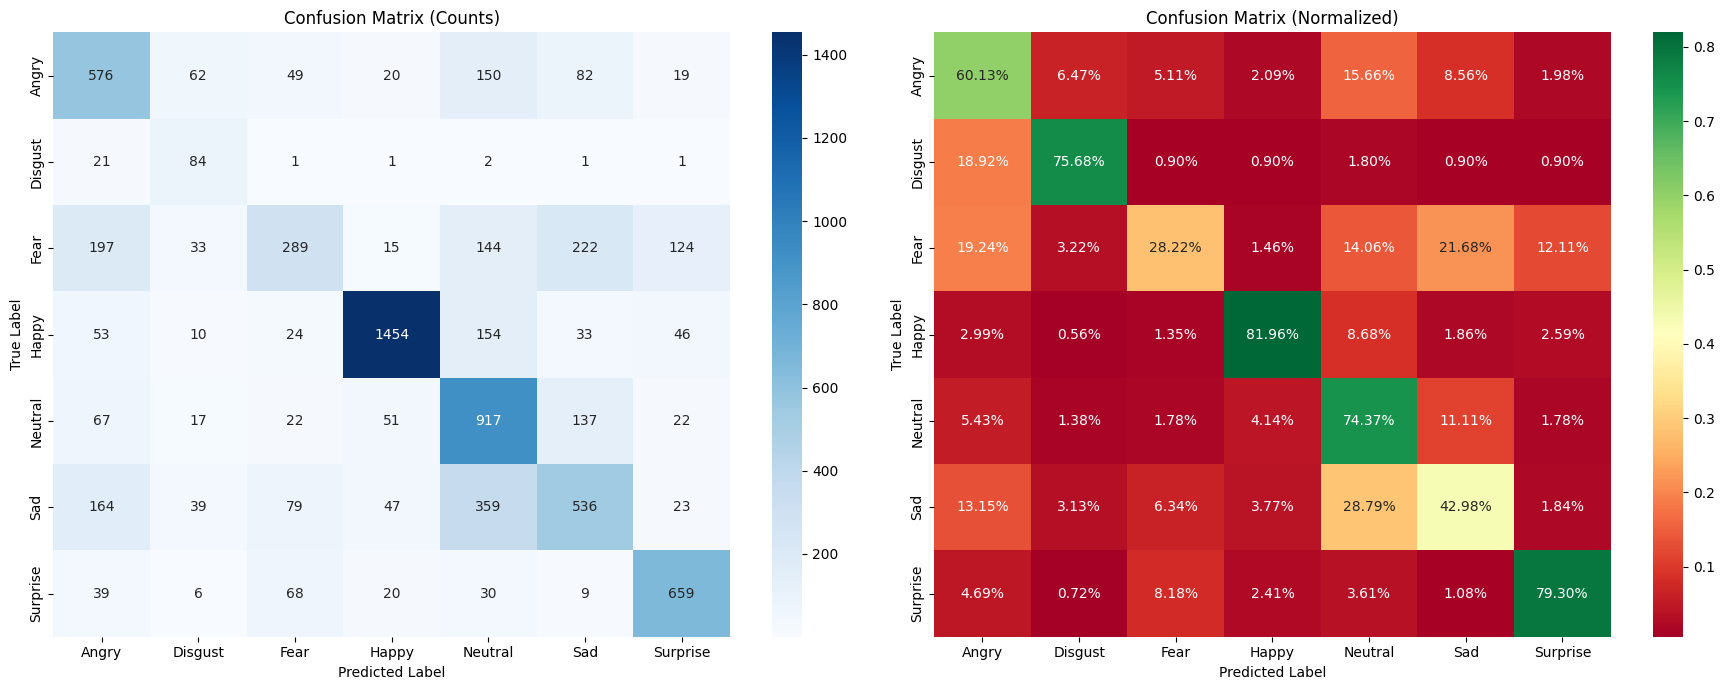

In [65]:
plot_confusion_matrix(y_true, y_pred, [e.capitalize() for e in emotions])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


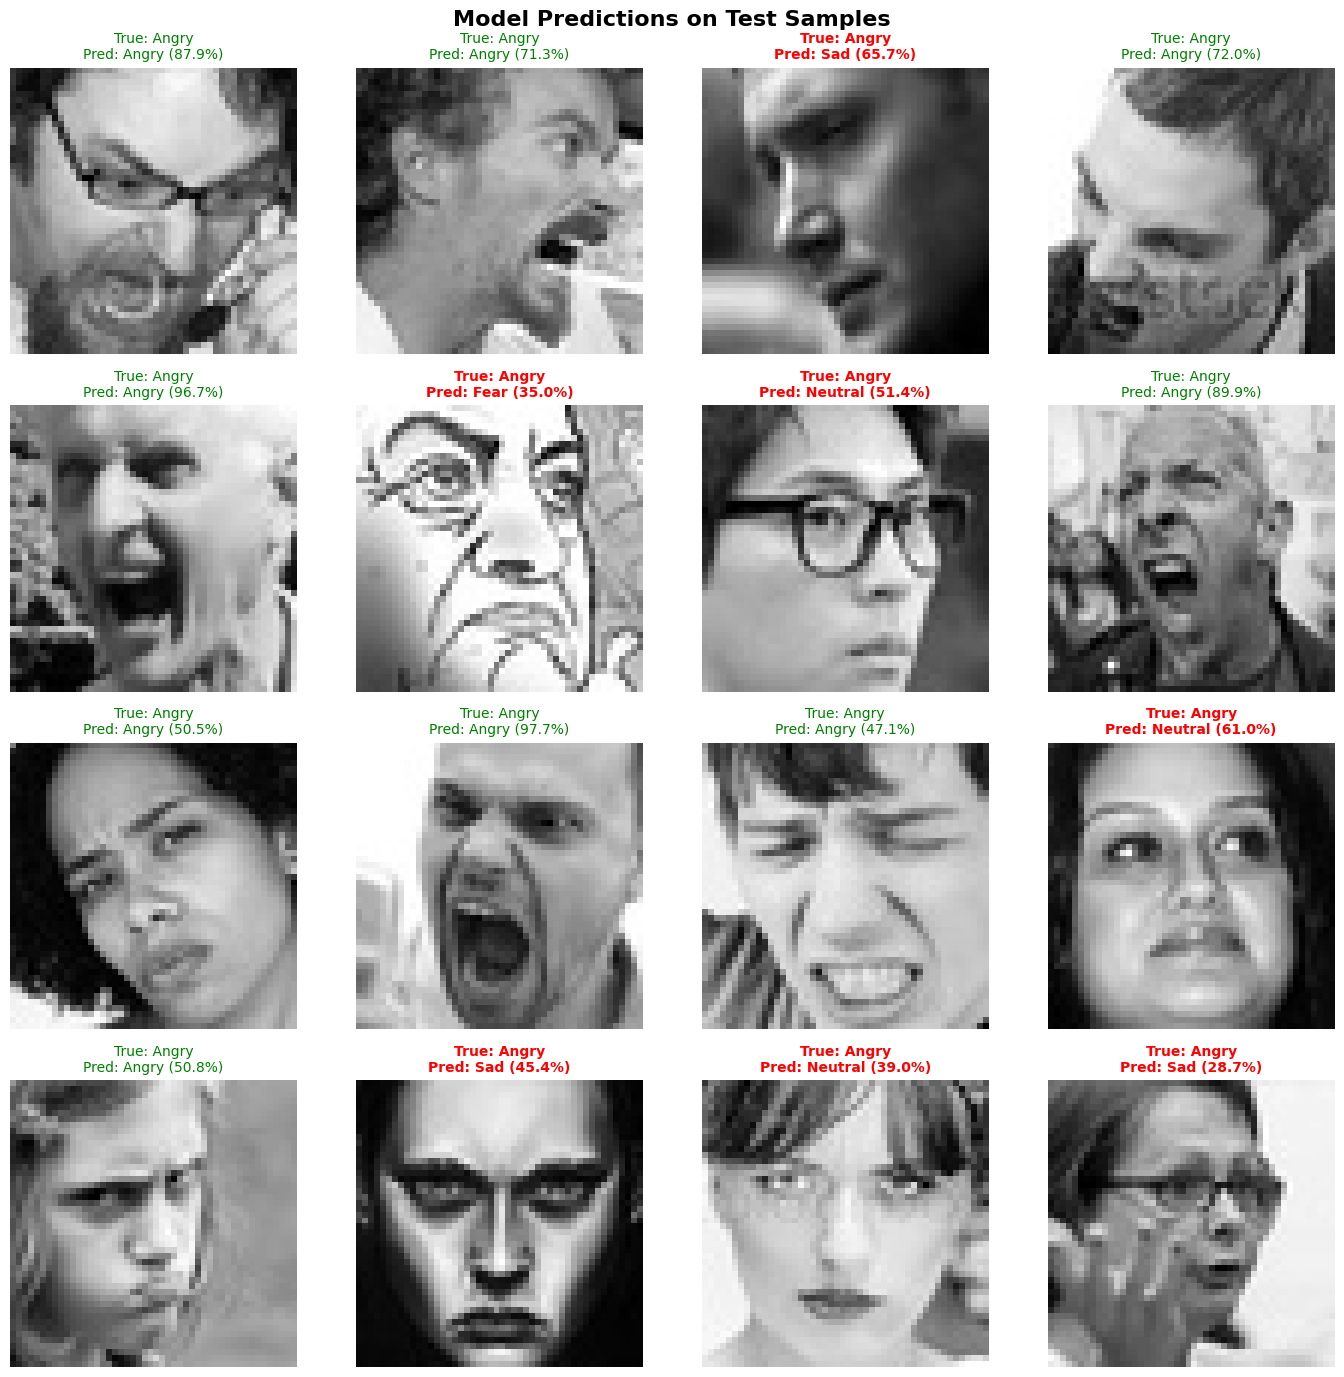

In [69]:
def visualize_predictions(model, test_generator, num_samples=16):


    test_generator.reset()
    batch_x, batch_y = next(test_generator)
    predictions = model.predict(batch_x)

    fig, axes = plt.subplots(4, 4, figsize=(14, 14))
    axes = axes.flatten()

    for i in range(min(num_samples, len(batch_x))):
        img = batch_x[i].reshape(image_size, image_size)
        true_label = emotions[np.argmax(batch_y[i])].capitalize()
        pred_label = emotions[np.argmax(predictions[i])].capitalize()
        confidence = np.max(predictions[i]) * 100

        correct = true_label == pred_label
        color = 'green' if correct else 'red'

        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(
            f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
            fontsize=10,
            color=color,
            fontweight='bold' if not correct else 'normal'
        )

    plt.suptitle('Model Predictions on Test Samples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('predictions_visualization.png', dpi=150)
    plt.show()

visualize_predictions(best_model, test_generator)

In [70]:
model.save("emotion_model.keras")

In [71]:
from google.colab import files
files.download("emotion_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>